# Library and dataset import section: 

In [1]:
!featurize dataset download 3b2d6527-7a46-4237-84b5-605c9f9165fa

100%|████████████████████████████████████████| 506M/506M [00:02<00:00, 190MiB/s]
🍬  下载完成，正在解压...
🏁  数据集已经成功添加


In [2]:
from PIL import Image, ImageChops, ImageEnhance
from torchvision import transforms
import os
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm, trange
import torch
import time
import torchvision.models as models

In [3]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data, io,data_dir,filters, feature
from skimage.color import label2rgb
import skimage
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
radius = 1 # LBP算法中范围半径的取值
n_points = 8 * radius # 领域像素点数

# Image pre-process section:

In [4]:
# Convert an image to ela image
# Input type: <class 'PIL.Image.Image'>
# Output type: <class 'PIL.Image.Image'>
image_size = (224, 224) 
def convert_to_lbp_image(path):
    image = cv2.imread(path)
    image.resize(image_size)
    image1 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(image1, n_points, radius)
    
    return lbp

In [5]:
# Resize image to fixed size
# Input type: <class 'PIL.Image.Image'>
# Output type: <class 'PIL.Image.Image'>
def prepare_image(image_path, image_size):
    convert_tensor = transforms.ToTensor()
    return convert_tensor(convert_to_lbp_image(image_path))

# Real image

In [6]:
# real images
X = [] # ELA converted images
Y = [] # label: 0 for fake, 1 for real


path = 'data/CASIA2000/Au'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        full_path = os.path.join(dirname, filename)
        X.append(prepare_image(full_path, image_size))
        Y.append(1)

print(len(X), len(Y))

960 960


# Fake image

In [7]:
# fake images

image_size = (224, 224) 
path = 'data/CASIA2000/Tp'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        full_path = os.path.join(dirname, filename)
        X.append(prepare_image(full_path, image_size))
        Y.append(0)

print(len(X), len(Y))

1920 1920


# Shuffle and split the data

In [8]:
# Shuffle the data
for i in range(10):
    X, Y = shuffle(X, Y, random_state=i)

In [9]:
# train, test, validation dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=42)
print(len(X_train), len(Y_train))
print(len(X_test), len(Y_test))
print(len(X_val), len(Y_val))

1382 1382
384 384
154 154


# VGG model

In [10]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 4096),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5), 
            nn.Linear(4096, 4096),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [11]:
def get_vgg_layers(config, batch_norm):
    layers = []
    conv2d = nn.Conv2d(1, 64, kernel_size=3, padding=1)
    layers += [conv2d, nn.BatchNorm2d(64), nn.LeakyReLU(inplace=True)]
    in_channels = 64
    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.LeakyReLU(inplace=True)]
            else:
                layers += [conv2d, nn.LeakyReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

In [12]:
# Binary classification: fake or real
vgg16_config = [64, 'M', 128, 128, 'M', 256, 256, 256, 'M']
vgg16_layers = get_vgg_layers(vgg16_config, batch_norm=True)

OUTPUT_DIM = 2
model = VGG(vgg16_layers, OUTPUT_DIM)

In [13]:
pretrained_model = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/featurize/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [14]:
IN_FEATURES = pretrained_model.classifier[-1].in_features

final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

pretrained_model.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)
# pretrained_model.features[1] = nn.BatchNorm2d(1)

pretrained_model.classifier[-1] = final_fc

pretrained_model.features = pretrained_model.features[:24]
pretrained_model.classifier = None

print(pretrained_model.classifier)
print(pretrained_model.features)


None
Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding

In [15]:
print(vgg16_layers)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01, inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.01, inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): LeakyReLU(negative_slope=0.01, inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): LeakyReLU(negative_slope=0.01, inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=

In [16]:
model.load_state_dict(pretrained_model.state_dict(), strict = False)

_IncompatibleKeys(missing_keys=['classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'], unexpected_keys=[])

In [17]:
# Learning rate
LR = 1e-3
params = [
          {'params': model.features.parameters(), 'lr': LR / 10},
          {'params': model.classifier.parameters()}
         ]
optimizer = optim.Adam(params, lr=LR, weight_decay = 0.001, amsgrad = True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [18]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

# Training stage

In [19]:
# Trains the model using backpropagation
# Input: torch.nn.Module, data.Dataloader, torch.optim.Optimizer, torch.nn.Module, torch.device
# Output: float, float

def train(model, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    x = X_train[0]
    y = torch.tensor(Y_train[0])
    count = 1
    for i in range(1, len(X_train)):
        x = torch.dstack((x, X_train[i]))
        y = torch.dstack((y, torch.tensor(Y_train[i])))
        count += 1
        if count % 64 == 0:
            x = x.reshape(-1,1,224,224)
            y = y.reshape(64,)
            x = x.to(device, dtype=torch.float)
            y = y.to(device)
            
            
            optimizer.zero_grad()
            y_pred, _ = model(x)

            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            x = X_train[i]
            y = torch.tensor(Y_train[i])
            count = 1
    
    return epoch_loss / (len(X_train)/64), epoch_acc / (len(X_train)/64)

In [20]:
# Calculates time elapsed for the whole training
# Input: float, float
# Output: int, int
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = elapsed_time // 60
    elapsed_secs = int(elapsed_time % 60)
    return elapsed_mins, elapsed_secs

In [21]:
# Calculates the loss and accuracy of the model with the given criterion
# Input: torch.nn.Module, data.Dataloader, torch.nn.Module, torch.device
# Output: float, float
def evaluate(model, X, Y, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    x = X[0]
    y = torch.tensor(Y[0])
    count = 1
    with torch.no_grad():
        for i in range(1, len(X)):
            x = torch.dstack((x, X[i]))
            y = torch.dstack((y, torch.tensor(Y[i])))
            count += 1
            if count % 64 == 0:
                x = x.reshape(-1,1,224,224)
                y = y.reshape(64,)
                x = x.to(device, dtype=torch.float)
                y = y.to(device)


                y_pred, _ = model(x)

                loss = criterion(y_pred, y)
                acc = calculate_accuracy(y_pred, y)

                epoch_loss += loss.item()
                epoch_acc += acc.item()

                x = X[i]
                y = torch.tensor(Y[i])
                count = 1
    

    return epoch_loss / (len(X)/64), epoch_acc / (len(X)/64)

In [22]:
EPOCHS = 30
best_valid_loss = float(10000)
best_epoch = -1
start_time = time.monotonic()
end_time = -1

Train_loss = []
Val_loss = []
for epoch in range(EPOCHS):

    train_loss, train_acc = train(model, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model,X_val, Y_val,criterion, device)


    # early stopping
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'vgg16-3layers-lbp.pt')
        end_time = time.monotonic()
        best_epoch = epoch
        best_valid_loss = valid_loss

    Train_loss.append(train_loss)
    Val_loss.append(valid_loss)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

if(end_time < 0):
  end_time = time.monotonic()
  best_epoch = EPOCHS
epoch_mins, epoch_secs = epoch_time(start_time, end_time)

Epoch: 01
	Train Loss: 2.088 | Train Acc: 47.83%
	Val. Loss: 0.574 |  Val. Acc: 45.45%
Epoch: 02
	Train Loss: 0.675 | Train Acc: 48.77%
	Val. Loss: 0.575 |  Val. Acc: 45.45%
Epoch: 03
	Train Loss: 0.675 | Train Acc: 48.70%
	Val. Loss: 0.581 |  Val. Acc: 37.66%
Epoch: 04
	Train Loss: 0.677 | Train Acc: 48.99%
	Val. Loss: 0.582 |  Val. Acc: 37.66%
Epoch: 05
	Train Loss: 0.677 | Train Acc: 48.99%
	Val. Loss: 0.583 |  Val. Acc: 37.66%
Epoch: 06
	Train Loss: 0.676 | Train Acc: 50.58%
	Val. Loss: 0.579 |  Val. Acc: 37.66%
Epoch: 07
	Train Loss: 0.676 | Train Acc: 49.78%
	Val. Loss: 0.572 |  Val. Acc: 45.45%
Epoch: 08
	Train Loss: 0.679 | Train Acc: 48.99%
	Val. Loss: 0.584 |  Val. Acc: 37.66%
Epoch: 09
	Train Loss: 0.676 | Train Acc: 50.94%
	Val. Loss: 0.580 |  Val. Acc: 37.66%
Epoch: 10
	Train Loss: 0.676 | Train Acc: 50.87%
	Val. Loss: 0.577 |  Val. Acc: 37.66%
Epoch: 11
	Train Loss: 0.676 | Train Acc: 49.78%
	Val. Loss: 0.582 |  Val. Acc: 37.66%
Epoch: 12
	Train Loss: 0.674 | Train Acc: 4

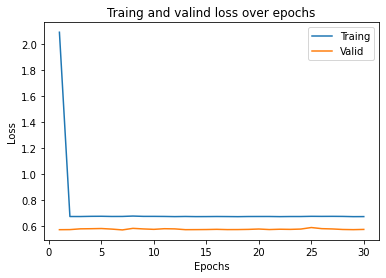

Lowest loss happens in epoch 7
Total Time Spent: 0.0m 45s
Test Loss: 0.711 | Test Acc: 43.49%


In [23]:
# LR = 1e-3
import matplotlib.pyplot as plt
  
plt.plot(range(1, EPOCHS + 1), Train_loss, label = "Traing")
plt.plot(range(1, EPOCHS + 1), Val_loss, label = "Valid")
plt.title('Traing and valind loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Evaluation
model.load_state_dict(torch.load('vgg16-3layers-lbp.pt'))
test_loss, test_acc = evaluate(model, X_test, Y_test, criterion, device)

print("Lowest loss happens in epoch " + str(best_epoch + 1))
print(f'Total Time Spent: {epoch_mins}m {epoch_secs}s')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')